# Microscopic 3-Temperature-Model

Here we adapt the NTM from the last example to allow for calculations of the magnetization within the microscopic 3-temperature-model as proposed by:

Koopmans, B., Malinowski, G., Dalla Longa, F. et al.  
*Explaining the paradoxical diversity of ultrafast laser-induced demagnetization.*  
[Nature Mater 9, 259–265 (2010).](https://doi.org/10.1038/nmat2593)

We need to solve the following coupled differential equations:

\begin{align}
c_e(T_e) \rho \frac{\partial T_e}{\partial t} & = & \frac{\partial}{\partial z}
\left( k_e(T_e) \frac{\partial T_e}{\partial z} \right)
- G_{ep}(T_e-T_p) + S(z, t) \\
c_p(T_p) \rho \frac{\partial T_p}{\partial t} & = & \frac{\partial}{\partial z}
\left( k_p(T_p) \frac{\partial T_p}{\partial z} \right)
+ G_{ep}(T_e-T_p) \\
\frac{\partial m}{\partial t} & = & R m \frac{T_p}{T_C}
\left( 1 - m \coth\left( \frac{m T_C}{T_e} \right) \right)
\end{align}

We treat the temperature of the 3rd subsystem as magnetization $m$.
For that we have to set its `heat_capacity` to $1/\rho$ and `thermal_conductivity` to zero.
We put the complete right term of the last equation in the `sub_system_coupling` term for the 3rd subsystem.
Here, we need to rewrite the kotangens hyperbolicus in Python as
$$\coth(x) = 1 + \frac{2}{e^{2x} - 1}$$

The values of the used parameters are not experimentally verified.

## Setup

Do all necessary imports and settings.

In [1]:
import udkm1Dsim as ud
u = ud.u #  import the pint unit registry from udkm1Dsim
import scipy.constants as constants
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
u.setup_matplotlib() #  use matplotlib with pint units

## Structure

 to the [structure-example](structure.ipynb) for more details.

In [2]:
Co = ud.Atom('Co')
Ni = ud.Atom('Ni')
CoNi = ud.AtomMixed('CoNi')
CoNi.add_atom(Co, 0.5)
CoNi.add_atom(Ni, 0.5)
Si = ud.Atom('Si')

In [3]:
prop_CoNi = {}
prop_CoNi['heat_capacity'] = ['0.1*T',
                              532*u.J/u.kg/u.K,
                              1/7000
                             ]
prop_CoNi['therm_cond'] = [20*u.W/(u.m *u.K),
                           80*u.W/(u.m *u.K),
                          0]

R = 25.3/1e-12
Tc = 1388
g = 4.0e18

prop_CoNi['sub_system_coupling'] = ['-{:f}*(T_0-T_1)'.format(g),
                                    '{:f}*(T_0-T_1)'.format(g),
                                    '{0:f}*T_2*T_1/{1:f}*(1-T_2* (1 + 2/(exp(2*T_2*{1:f}/T_0) - 1) ))'.format(R, Tc)
                                    ]
prop_CoNi['lin_therm_exp'] = [0, 11.8e-6, 0]
prop_CoNi['sound_vel'] = 4.910*u.nm/u.ps
prop_CoNi['opt_ref_index'] = 2.9174+3.3545j

layer_CoNi = ud.AmorphousLayer('CoNi', 'CoNi amorphous', thickness=1*u.nm,
    density=7000*u.kg/u.m**3, atom=CoNi, **prop_CoNi)

Number of subsystems changed from 1 to 3.


In [4]:
prop_Si = {}
prop_Si['heat_capacity'] = [100*u.J/u.kg/u.K, 603*u.J/u.kg/u.K, 1]
prop_Si['therm_cond'] = [0, 100*u.W/(u.m *u.K), 0]

prop_Si['sub_system_coupling'] = [0, 0, 0]

prop_Si['lin_therm_exp'] = [0, 2.6e-6, 0]
prop_Si['sound_vel'] = 8.433*u.nm/u.ps
prop_Si['opt_ref_index'] = 3.6941+0.0065435j

layer_Si = ud.AmorphousLayer('Si', "Si amorphous", thickness=1*u.nm,
    density=2336*u.kg/u.m**3, atom=Si, **prop_Si)

Number of subsystems changed from 1 to 3.


In [5]:
S = ud.Structure('CoNi')

S.add_sub_structure(layer_CoNi, 20)
S.add_sub_structure(layer_Si, 50)

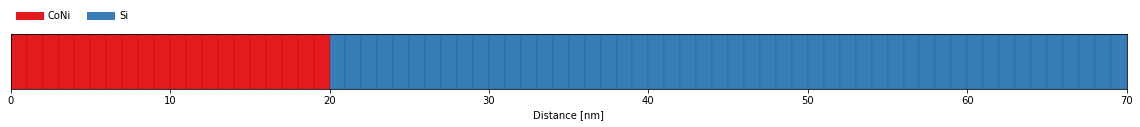

In [6]:
S.visualize()

## Initialize Heat and the Excitation

In [7]:
h = ud.Heat(S, True)

h.save_data = False
h.disp_messages = True

In [8]:
h.excitation = {'fluence': [30]*u.mJ/u.cm**2,
                'delay_pump':  [0]*u.ps,
                'pulse_width':  [0.05]*u.ps,
                'multilayer_absorption': True,
                'wavelength': 800*u.nm,
                'theta': 45*u.deg}
# temporal and spatial grid
delays = np.r_[-1:5:0.005]*u.ps
_, _, distances = S.get_distances_of_layers()

## Calculate Heat Diffusion

The `init_temp` sets the magnetization in the 3rd subsystem to `1` for CoNi and `0` for Si.

In [9]:
# enable heat diffusion
h.heat_diffusion = True
# set the boundary conditions
h.boundary_conditions = {'top_type': 'isolator', 'bottom_type': 'isolator'}
# The resulting temperature profile is calculated in one line:

init_temp = np.ones([S.get_number_of_layers(), 3])
init_temp[:, 0] = 300
init_temp[:, 1] = 300
init_temp[20:, 2] = 0

temp_map, delta_temp = h.get_temp_map(delays, init_temp)

Surface incidence fluence scaled by factor 0.7071 due to incidence angle theta=45.00 deg
Calculating _heat_diffusion_ ...
Absorption profile is calculated by multilayer formalism.
Total reflectivity of 42.4 % and transmission of 28.4 %.


0it [00:00, ?it/s]

Elapsed time for _heat_diffusion_: 1.116868 s
Calculating _heat_diffusion_ for excitation 1:1 ...
Absorption profile is calculated by multilayer formalism.
Total reflectivity of 42.4 % and transmission of 28.4 %.


0it [00:00, ?it/s]

Elapsed time for _heat_diffusion_ with 1 excitation(s): 2.869754 s
Calculating _heat_diffusion_ ...
Absorption profile is calculated by multilayer formalism.
Total reflectivity of 42.4 % and transmission of 28.4 %.


0it [00:00, ?it/s]

Elapsed time for _heat_diffusion_: 9.131454 s
Elapsed time for _temp_map_: 13.188387 s


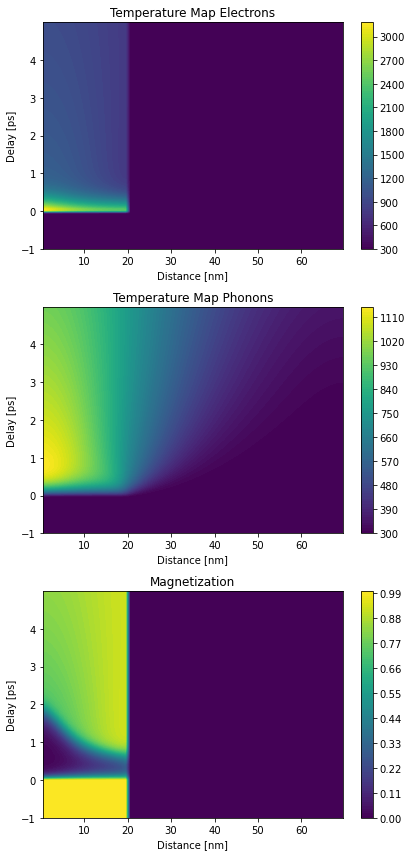

In [10]:
plt.figure(figsize=[6, 12])
plt.subplot(3, 1, 1)
plt.contourf(distances.to('nm').magnitude, delays.to('ps').magnitude, temp_map[:, :, 0], levels=100)
plt.colorbar()
plt.xlabel('Distance [nm]')
plt.ylabel('Delay [ps]')
plt.title('Temperature Map Electrons')

plt.subplot(3, 1, 2)
plt.contourf(distances.to('nm').magnitude, delays.to('ps').magnitude, temp_map[:, :, 1], levels=100)
plt.colorbar()
plt.xlabel('Distance [nm]')
plt.ylabel('Delay [ps]')
plt.title('Temperature Map Phonons')

plt.subplot(3, 1, 3)
plt.contourf(distances.to('nm').magnitude, delays.to('ps').magnitude, temp_map[:, :, 2], levels=100)
plt.colorbar()
plt.xlabel('Distance [nm]')
plt.ylabel('Delay [ps]')
plt.title('Magnetization')

plt.tight_layout()
plt.show()

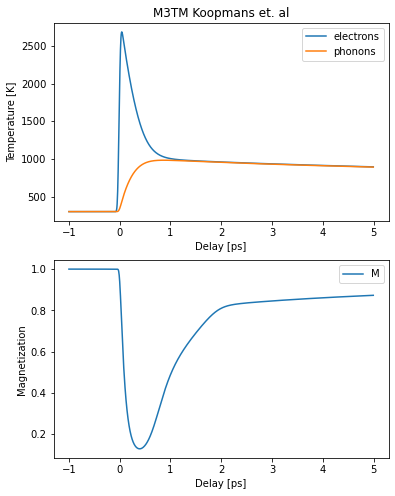

In [11]:
plt.figure(figsize=[6,8])
plt.subplot(2,1,1)
plt.plot(delays.to('ps'), np.mean(temp_map[:, S.get_all_positions_per_unique_layer()['CoNi'], 0], 1), label='electrons')
plt.plot(delays.to('ps'), np.mean(temp_map[:, S.get_all_positions_per_unique_layer()['CoNi'], 1], 1), label='phonons')
plt.ylabel('Temperature [K]')
plt.xlabel('Delay [ps]')
plt.legend()
plt.title('M3TM Koopmans et. al')

plt.subplot(2,1,2)

plt.plot(delays.to('ps'), np.mean(temp_map[:, S.get_all_positions_per_unique_layer()['CoNi'], 2], 1), label='M')
plt.ylabel('Magnetization')
plt.xlabel('Delay [ps]')
plt.legend()
plt.show()